<a href="https://colab.research.google.com/github/RufinoMartin/DataScience2021/blob/main/Restricciones_Covid_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este notebook se nutre de tres datasets en formato .csv, que pueden ser hallados en su formato original en el Github de Oxford Covid-19 Government Response Tracker:

https://github.com/OxCGRT

In [1]:
# Importacion Librerias

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import pandas_profiling
from functools import reduce
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


Por el gran tamaño de los datasets, se ha realizado una digestion previa de los mismos. 

( Para acceder al notebook preliminar donde se realizó dicha labor:

 https://github.com/RufinoMartin/DataScience2021/blob/main/CovidDigest.ipynb)
 
 El resultado de la misma ha sido un unico dataset, que procedemos a importar, y que de no funcionar el pd.read, dirigirse a al link
 https://github.com/RufinoMartin/DataScience2021/blob/main/CovidTrack.csv
 , copiar el URL del Raw, y pegar:
 
 

In [2]:
df_CovidTrack = pd.read_csv('https://raw.githubusercontent.com/RufinoMartin/DataScience2021/main/CovidTrack.csv?token=GHSAT0AAAAAABRYGSF2ZCF6IQEVVN3UIC56YRXMGQA')

El grueso de columnas del dataset fueron dropeadas por redundancia, conservando unicamente aquellas cuyas variables nos son de interes: 
**Los Indices de Politicas Publicas** confeccionados por Oxford. Estos nuclean y representan varias variables: 

- 'StringencyIndex': Indice de Rigor 
(Confinamientos, restricciones, prohibiciones)

- 'GovernmentResponseIndex' : Indice de Respuesta Gubernamental General.
(reune todos los indicadores)

- 'ContainmentHealthIndex' : Indice de Contencion en Salud. 
(Regimen de testeos e inversion en salud)

- 'EconomicSupportIndex' : Indice de Apoyo Economico. 
(apoyo economico a los ciudadanos locales y extranjeros)

En la documentacion se citan y desarrollan dichos indices, que utilizamos conjuntamente para nuestra variable:

**"Restricciones COVID"**

In [3]:
df_CovidTrack.shape

(8424, 7)

In [4]:
df_CovidTrack.dtypes

Unnamed: 0                   int64
CountryName                 object
Date                         int64
StringencyIndex            float64
GovernmentResponseIndex    float64
ContainmentHealthIndex     float64
EconomicSupportIndex       float64
dtype: object

In [5]:
df_CovidTrack.describe()

,Unnamed: 0,Date,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex
count,8424.000000,8.424000e+03,8096.000000,8094.000000,8094.000000,8216.000000
mean,1715.500000,2.020727e+07,49.695195,50.122034,51.897195,37.766249
std,1114.128928,6.575934e+03,23.433324,20.028812,20.451647,30.681073
min,0.000000,2.020010e+07,0.000000,0.000000,0.000000,0.000000
25%,701.750000,2.020070e+07,35.190000,42.970000,44.940000,0.000000
50%,1637.500000,2.021020e+07,52.310000,54.690000,56.550000,37.500000
75%,2690.250000,2.021090e+07,66.670000,63.850000,65.770000,62.500000
max,3743.000000,2.022030e+07,100.000000,91.150000,93.450000,100.000000


**Observaciones a primera vista:**

1) la media para todos los indices se sostiene en 37-51%. 

2) Los indices guardan fuerte correlacion entre si. Es tentador querer explicarlo por los indicadores que entre ellos comparten (decenas de variables con las cuales se componen). Sin embargo, esto solo es cierto para el Indice de Respuesta General Gubernamental ('GovermentResponse'). Los otros indices estan bien delimitados y definidos, y comparten mas bien pocos indicadores entre si (ver documentacion). 

3) Los cuatro indices presentan gran interes para analisis, mas o menos especificos. De pensar en utilizarlos para establecer relaciones con el precio de indices bursatiles y de commodities, sin embargo, surgen dos vias:

 a. Utilizar solamente el indice de Respuesta General Gubernamental, que nuclea todos los indicadores.

 b.Utilizar los tres Indices (de Rigor, Economico y Sanitario), excluyendo al de respuesta general por redundancia. 

In [6]:
df_CovidTrack.drop(columns={'Unnamed: 0'}, inplace=True)
df_CovidTrack.head(5)

,CountryName,Date,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex
0,Aruba,20200101,0.00,0.00,0.00,0.0
1,Aruba,20200201,0.00,0.00,0.00,0.0
2,Aruba,20200301,0.00,0.00,0.00,0.0
3,Aruba,20200401,85.19,70.31,67.86,87.5
4,Aruba,20200501,85.19,70.31,67.86,87.5


Como se puede observar, para cada pais solo estan los meses del 2020 a la vista.  El motivo de esto, es que el dataframe está concatenado, con lo cual "Aruba del 2021",  vuelve a aparecer luego de "Zimbabwe del 2020". Procedemos a ordenar ello.

In [7]:
df_CovidTrack = df_CovidTrack.sort_values(['CountryName', 'Date'], ascending=[True, True])
df_CovidTrack.head(30)

,CountryName,Date,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex
12,Afghanistan,20200101,0.00,0.00,0.00,0.0
13,Afghanistan,20200201,0.00,0.00,0.00,0.0
14,Afghanistan,20200301,27.78,22.92,26.19,0.0
15,Afghanistan,20200401,67.59,48.44,55.36,0.0
16,Afghanistan,20200501,84.26,62.50,67.86,25.0
17,Afghanistan,20200601,84.26,59.38,67.86,0.0
18,Afghanistan,20200701,78.70,60.42,69.05,0.0
19,Afghanistan,20200801,78.70,60.42,69.05,0.0
20,Afghanistan,20200901,21.30,35.42,40.48,0.0
21,Afghanistan,20201001,28.70,30.21,34.52,0.0


In [8]:
#Reindexamos

df_CovidTrack = df_CovidTrack.reset_index(drop=True)
df_CovidTrack.head(30)

,CountryName,Date,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex
0,Afghanistan,20200101,0.00,0.00,0.00,0.0
1,Afghanistan,20200201,0.00,0.00,0.00,0.0
2,Afghanistan,20200301,27.78,22.92,26.19,0.0
3,Afghanistan,20200401,67.59,48.44,55.36,0.0
4,Afghanistan,20200501,84.26,62.50,67.86,25.0
5,Afghanistan,20200601,84.26,59.38,67.86,0.0
6,Afghanistan,20200701,78.70,60.42,69.05,0.0
7,Afghanistan,20200801,78.70,60.42,69.05,0.0
8,Afghanistan,20200901,21.30,35.42,40.48,0.0
9,Afghanistan,20201001,28.70,30.21,34.52,0.0


In [9]:
# Reordenamos las columnas, dejando ultima la de Respuesta General Gubernamental, ya que seria un "Indice de Indices"

TitulosColumnas = ['CountryName', 'Date', 'StringencyIndex', 'ContainmentHealthIndex','EconomicSupportIndex','GovernmentResponseIndex']

df_CovidTrack = df_CovidTrack.reindex(columns=TitulosColumnas)

In [10]:
df_CovidTrack.head(1)

,CountryName,Date,StringencyIndex,ContainmentHealthIndex,EconomicSupportIndex,GovernmentResponseIndex
0,Afghanistan,20200101,0.0,0.0,0.0,0.0


In [ ]:
# Mejoramos la apariencia y usabilidad de la columna Date.

In [11]:
df_CovidTrack.Date.dtypes

dtype('int64')

In [12]:
# Es necesario pasar la columna a tipo string primero, ya que es el tipo de datos que admite la funcion DateTime. 

df_CovidTrack['DateTime'] = pd.to_datetime(df_CovidTrack['Date'].astype(str), format='%Y%m%d')
df_CovidTrack.head(3)

,CountryName,Date,StringencyIndex,ContainmentHealthIndex,EconomicSupportIndex,GovernmentResponseIndex,DateTime
0,Afghanistan,20200101,0.00,0.00,0.0,0.00,2020-01-01
1,Afghanistan,20200201,0.00,0.00,0.0,0.00,2020-02-01
2,Afghanistan,20200301,27.78,26.19,0.0,22.92,2020-03-01


In [13]:
# Nos quedamos solo con DateTime.

df_CovidTrack.drop(columns={'Date'}, inplace=True)

In [14]:
# Reordenamos 

Tituloscolumnas2 = ['CountryName','DateTime','StringencyIndex','ContainmentHealthIndex','EconomicSupportIndex','GovernmentResponseIndex']
df_CovidTrack = df_CovidTrack.reindex(columns=Tituloscolumnas2)

In [15]:
df_CovidTrack.head(25)

,CountryName,DateTime,StringencyIndex,ContainmentHealthIndex,EconomicSupportIndex,GovernmentResponseIndex
0,Afghanistan,2020-01-01,0.00,0.00,0.0,0.00
1,Afghanistan,2020-02-01,0.00,0.00,0.0,0.00
2,Afghanistan,2020-03-01,27.78,26.19,0.0,22.92
3,Afghanistan,2020-04-01,67.59,55.36,0.0,48.44
4,Afghanistan,2020-05-01,84.26,67.86,25.0,62.50
5,Afghanistan,2020-06-01,84.26,67.86,0.0,59.38
6,Afghanistan,2020-07-01,78.70,69.05,0.0,60.42
7,Afghanistan,2020-08-01,78.70,69.05,0.0,60.42
8,Afghanistan,2020-09-01,21.30,40.48,0.0,35.42
9,Afghanistan,2020-10-01,28.70,34.52,0.0,30.21


In [ ]:
#    A considerar: ¿Resulta util y/o necesario un nuevo recorte/seleccion/sintetsis del dataframe?
#
#     - CountryName: Es posible, con criterio declarado, realizar un recorte de paises en base a una "seleccion representativa regional/continental"
#     - Date: Es necesario conservar los 12 meses de cada año > no puede reducirse.
#     - Indices: Como desarrollado mas arriba, caben aqui tres opciones:
#         1. Conservar los 4 indices por riqueza de analisis.
#         2. Conservar 3 Indices especificos y descartar el de respuesta general.
#         3. Conservar el de respuesta general y descartar los 3 Indices especificos. 


In [16]:
df_CovidTrack.shape

(8424, 6)

In [17]:
#Renombramos todo

df_Restricciones_Covid = df_CovidTrack

In [18]:
#Guardamos cambios 

df_Restricciones_Covid.to_csv('Restricciones_Covid.csv')

In [ ]:
df_CovidTrack.info

<bound method DataFrame.info of       CountryName   DateTime  StringencyIndex  ContainmentHealthIndex  EconomicSupportIndex  GovernmentResponseIndex
0     Afghanistan 2020-01-01             0.00                    0.00                   0.0                     0.00
1     Afghanistan 2020-02-01             0.00                    0.00                   0.0                     0.00
2     Afghanistan 2020-03-01            27.78                   26.19                   0.0                    22.92
3     Afghanistan 2020-04-01            67.59                   55.36                   0.0                    48.44
4     Afghanistan 2020-05-01            84.26                   67.86                  25.0                    62.50
...           ...        ...              ...                     ...                   ...                      ...
8419     Zimbabwe 2021-11-01            44.44                   53.57                   0.0                    46.88
8420     Zimbabwe 2021-12-01    

ANALISIS MULTIVARIADO EXPLORATORIO

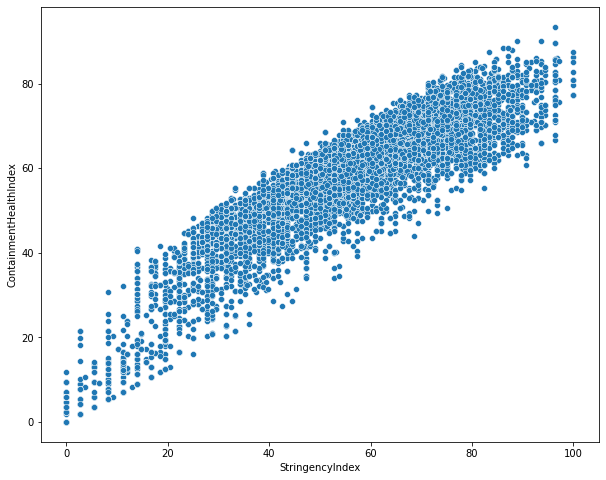

In [ ]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='StringencyIndex',y='ContainmentHealthIndex',data=df_CovidTrack)
plt.show()

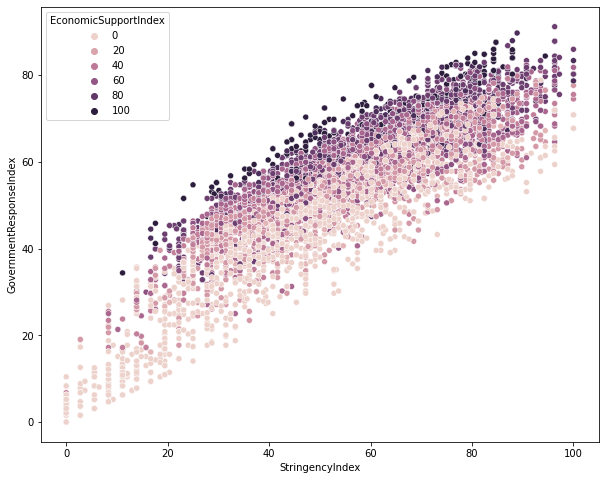

In [ ]:
plt.figure(figsize=(10,8))
sns.scatterplot(x='StringencyIndex',y='GovernmentResponseIndex',data=df_CovidTrack,hue='EconomicSupportIndex')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



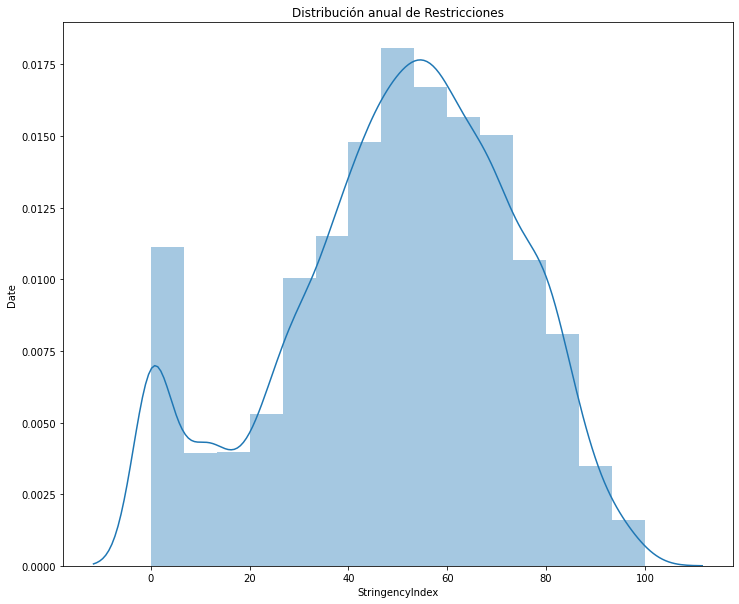

In [ ]:
# Distribucion anual para la variable StringencyIndex 

plt.figure(figsize=(12,10))

sns.distplot(df_CovidTrack.StringencyIndex, kde=True, hist=True, bins=15)
plt.xlabel('StringencyIndex')
plt.ylabel('Date')
plt.title('Distribución anual de Restricciones')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



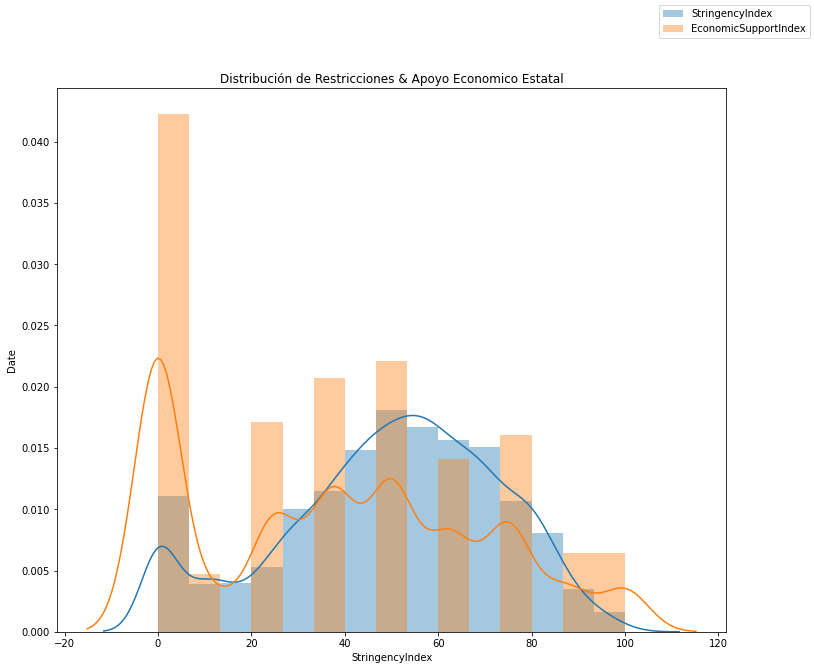

In [ ]:
#Grafico compartido para las distribuciones de Restricciones y Apoyo Economico. 

fig = plt.figure(figsize=(12,10))

sns.distplot(df_CovidTrack.StringencyIndex, kde=True, hist=True, bins=15, label='StringencyIndex')
sns.distplot(df_CovidTrack.EconomicSupportIndex, kde=True, hist=True, bins=15, label='EconomicSupportIndex')

fig.legend()
plt.xlabel('StringencyIndex')
plt.ylabel('Date')
plt.title('Distribución de Restricciones & Apoyo Economico Estatal')

plt.show()